In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#checking the path because I had some issues when inputting periods
print(engine.url.database)

Resources/hawaii.sqlite


In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [15]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [16]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [24]:
# Find the most recent date in the data set. func max is used to find the most recent dat in tha measurement column. 
#.scalar because I'm looking for one result
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date

'2017-08-23'

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-24'),
  Text(500.0, 0, '2016-11-10'),
  Text(1000.0, 0, '2017-01-29'),
  Text(1500.0, 0, '2017-04-19'),
  Text(2000.0, 0, '2017-07-11'),
  Text(2500.0, 0, '')])

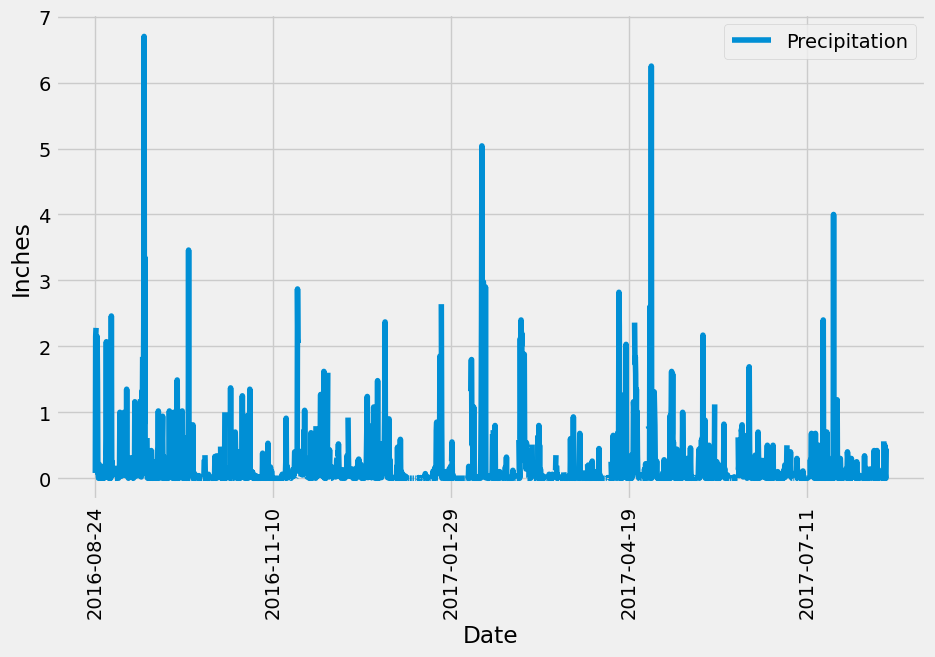

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)

In [26]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
summary_statistics

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

total_stations

9

In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(
    sqlalchemy.func.min(Measurement.tobs).label('min_temp'),
    sqlalchemy.func.max(Measurement.tobs).label('max_temp'),
    sqlalchemy.func.round(sqlalchemy.func.avg(Measurement.tobs), 2).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Most Active Station ({most_active_station_id}) Temperature Statistics:")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp}°F")


Most Active Station (USC00519281) Temperature Statistics:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


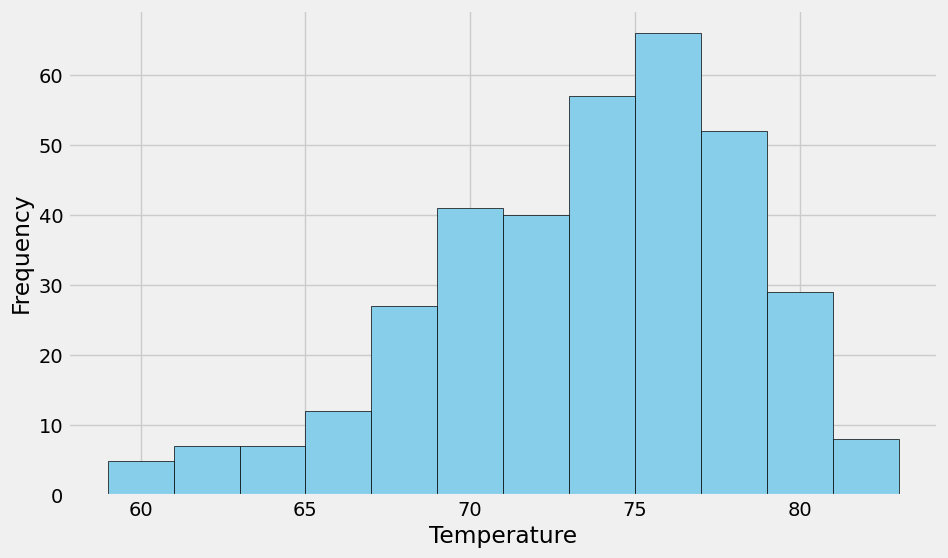

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs) \
    .filter(and_(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago)) \
    .all()
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [41]:
# Close Session
session.close()